<h3>Cutlist Optimizer</h3>
<p>Need to optimize wastage from 30.66% to 18%</p>

Total stock area: 650.580 sq m
Total glass area: 451.142 sq m
Total sheets used: 120
Used area percentage: 69.34%
Wastage percentage: 30.66%

Summary of sheet sizes used:
  2438mm x 2100mm: 100 pcs
  3300mm x 2100mm: 20 pcs


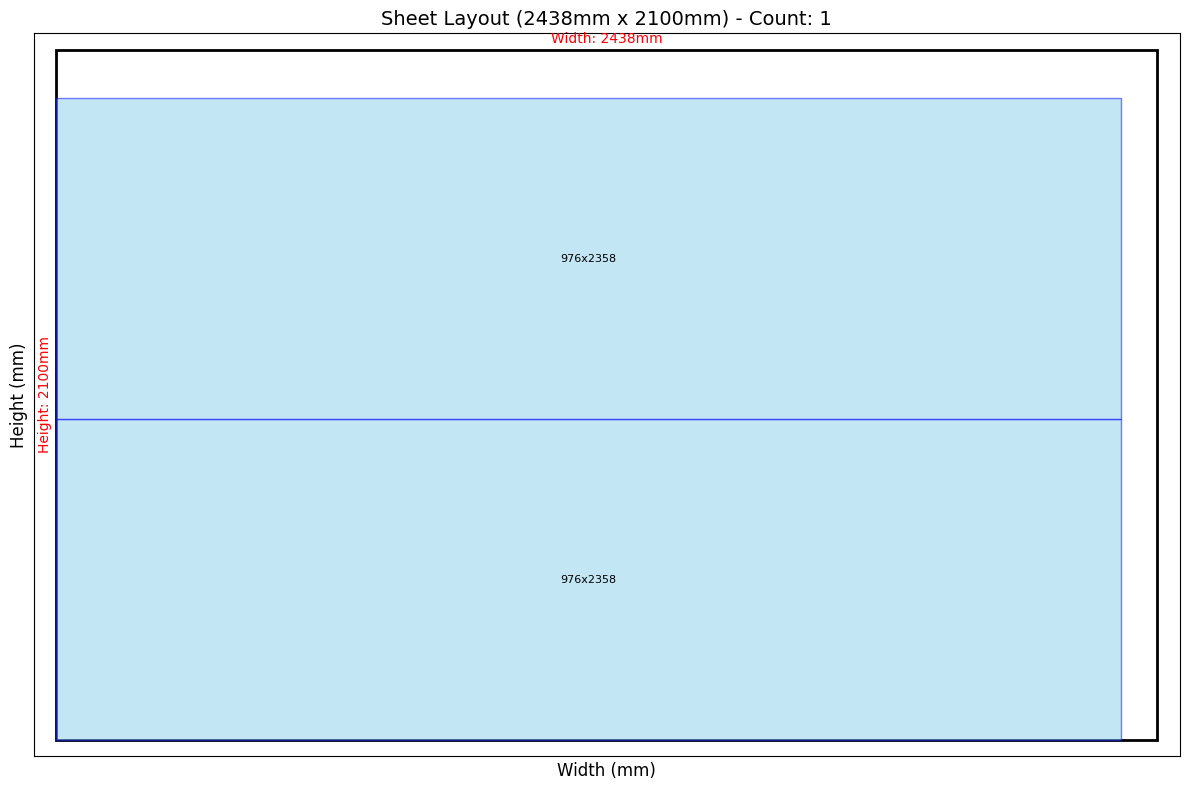

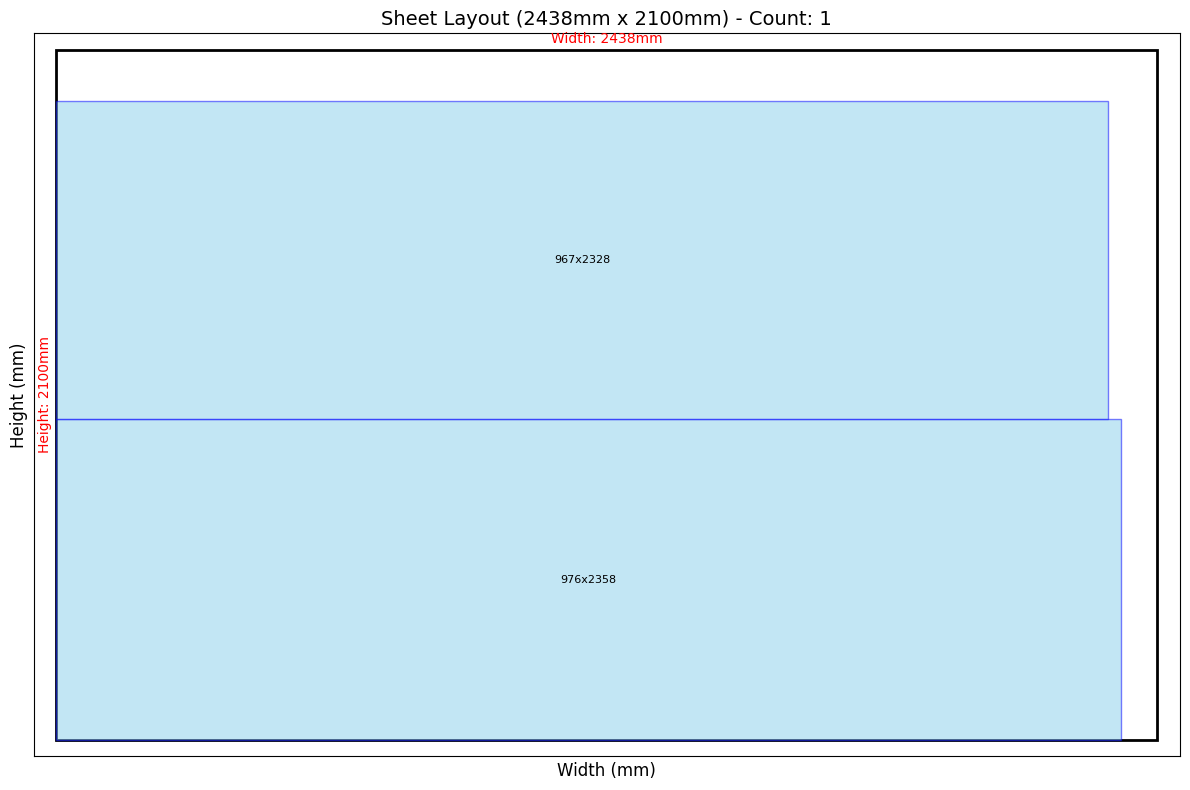

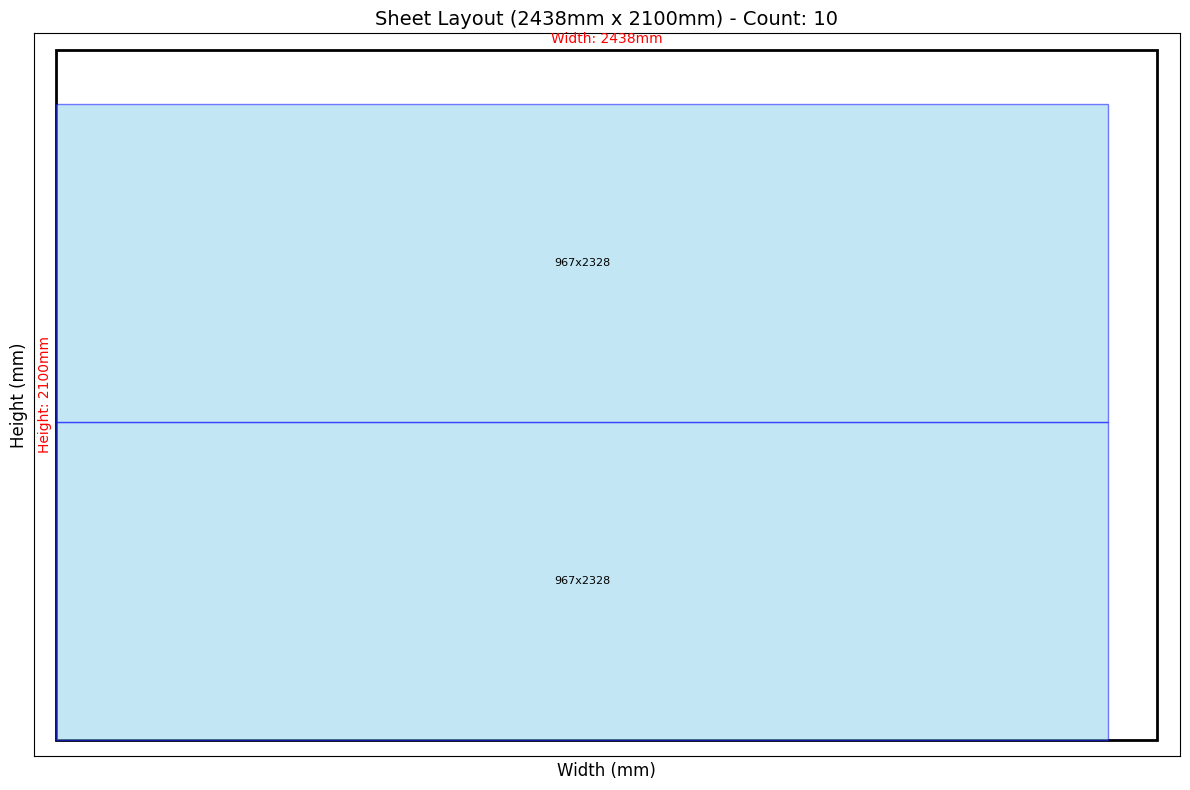

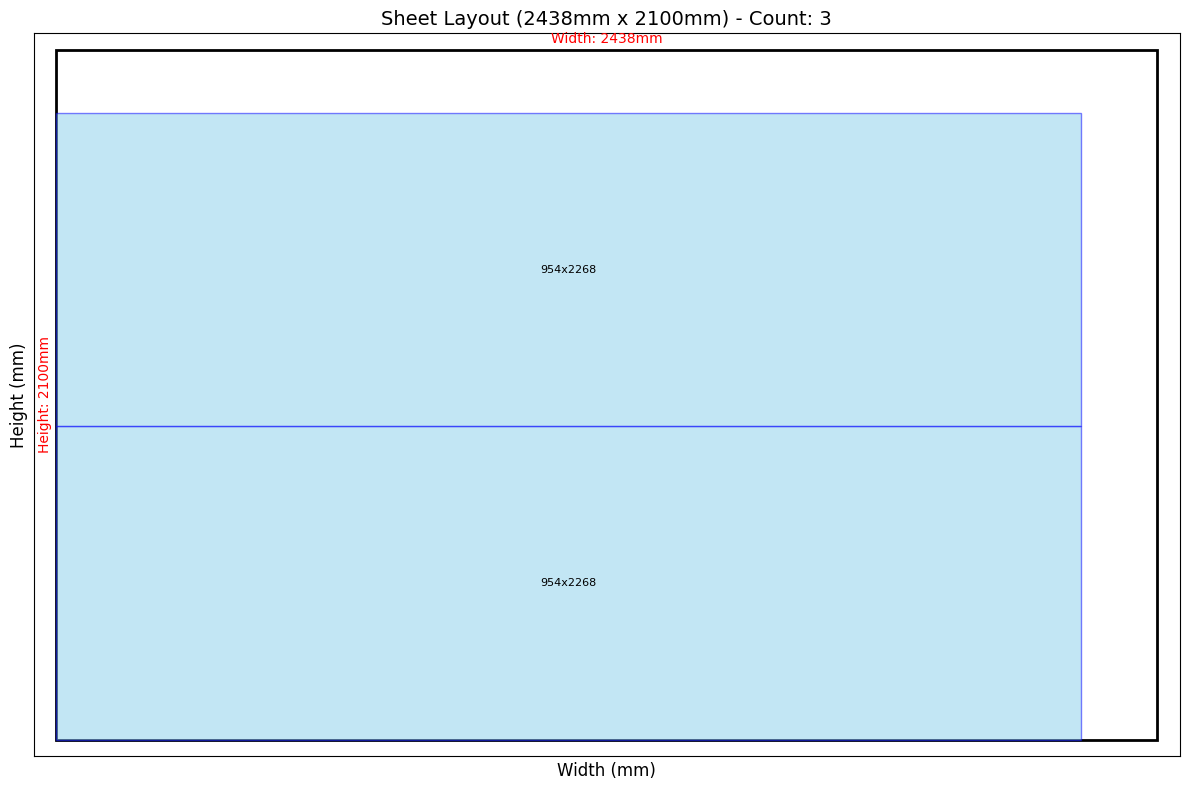

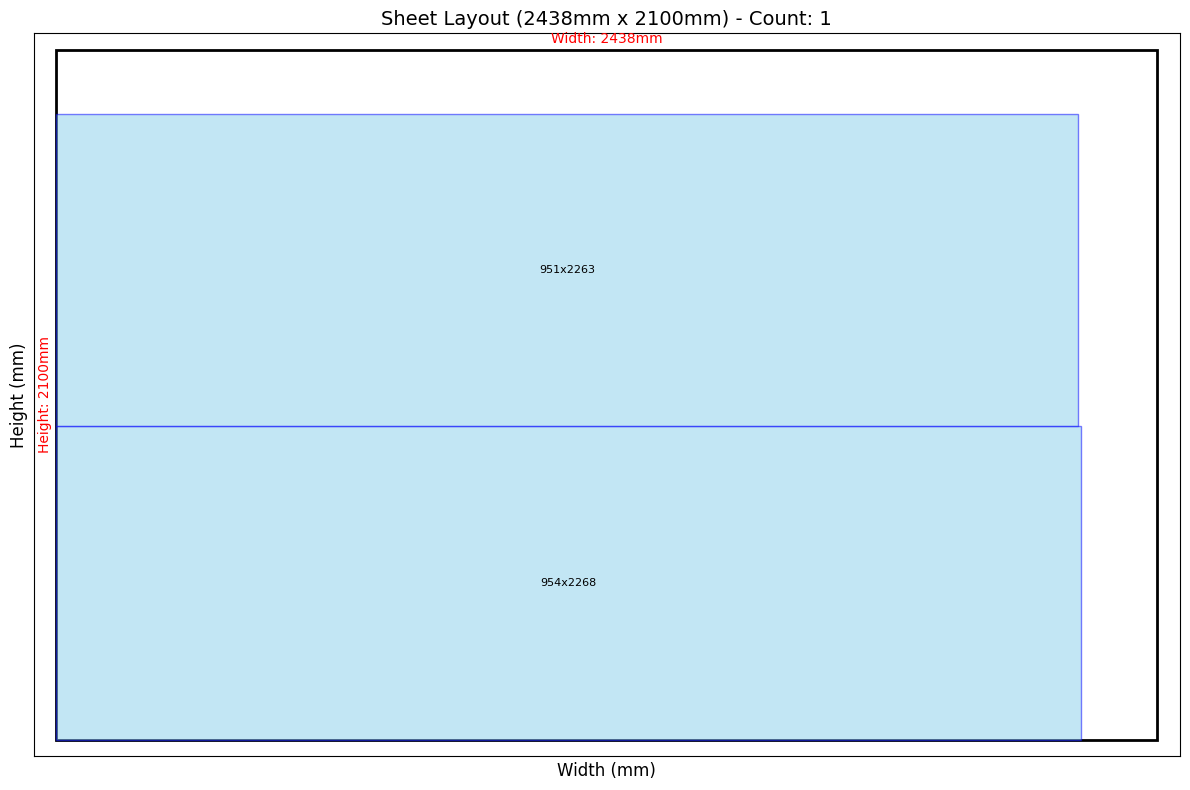

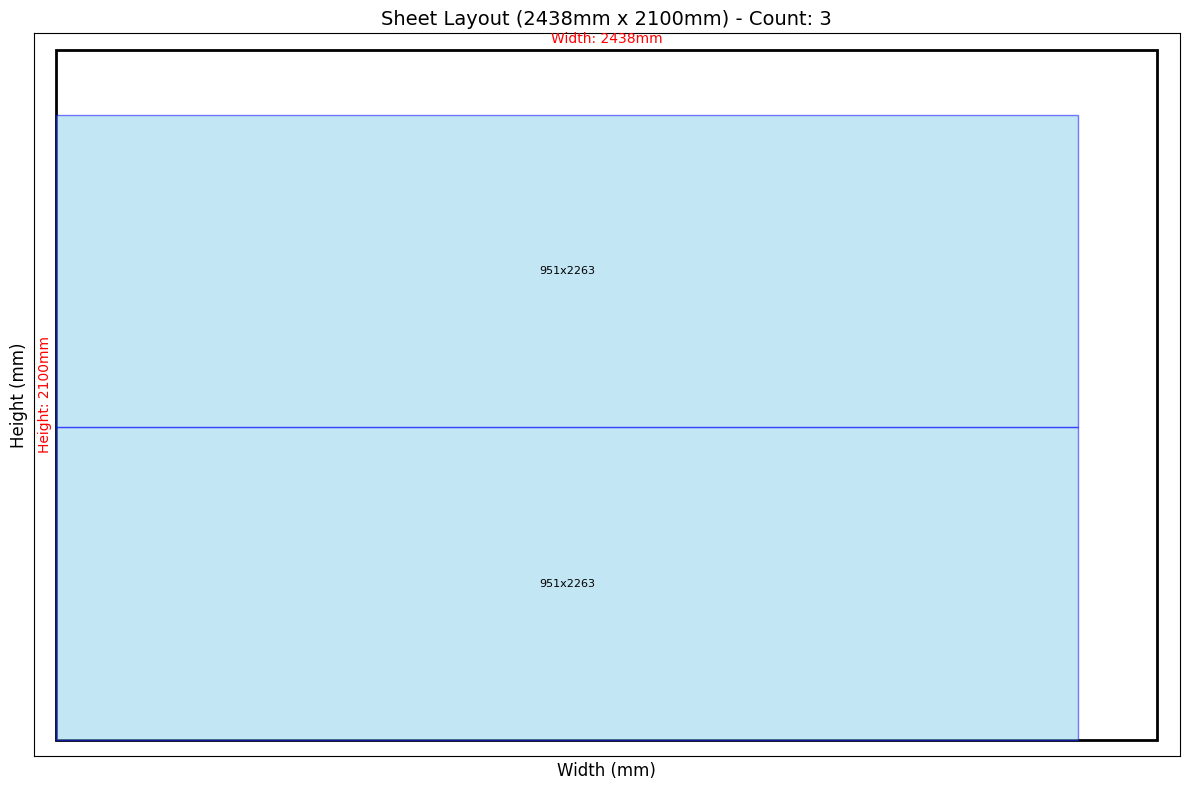

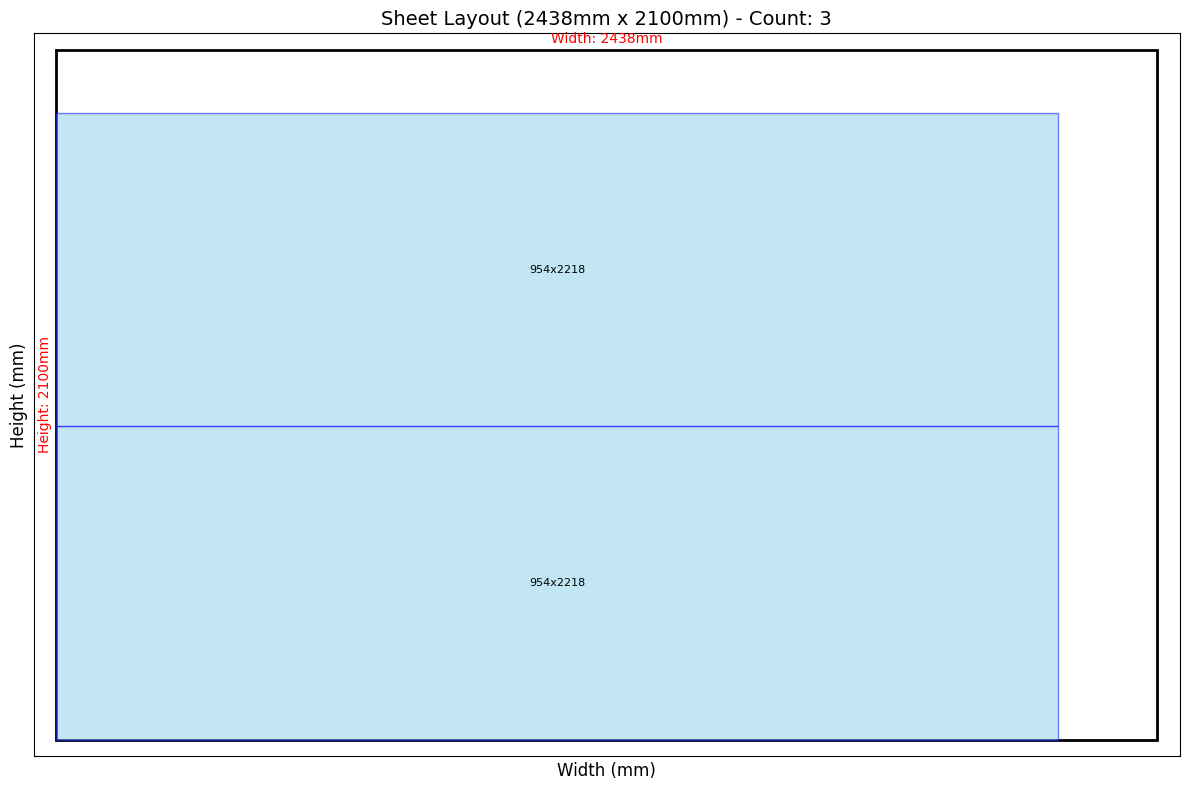

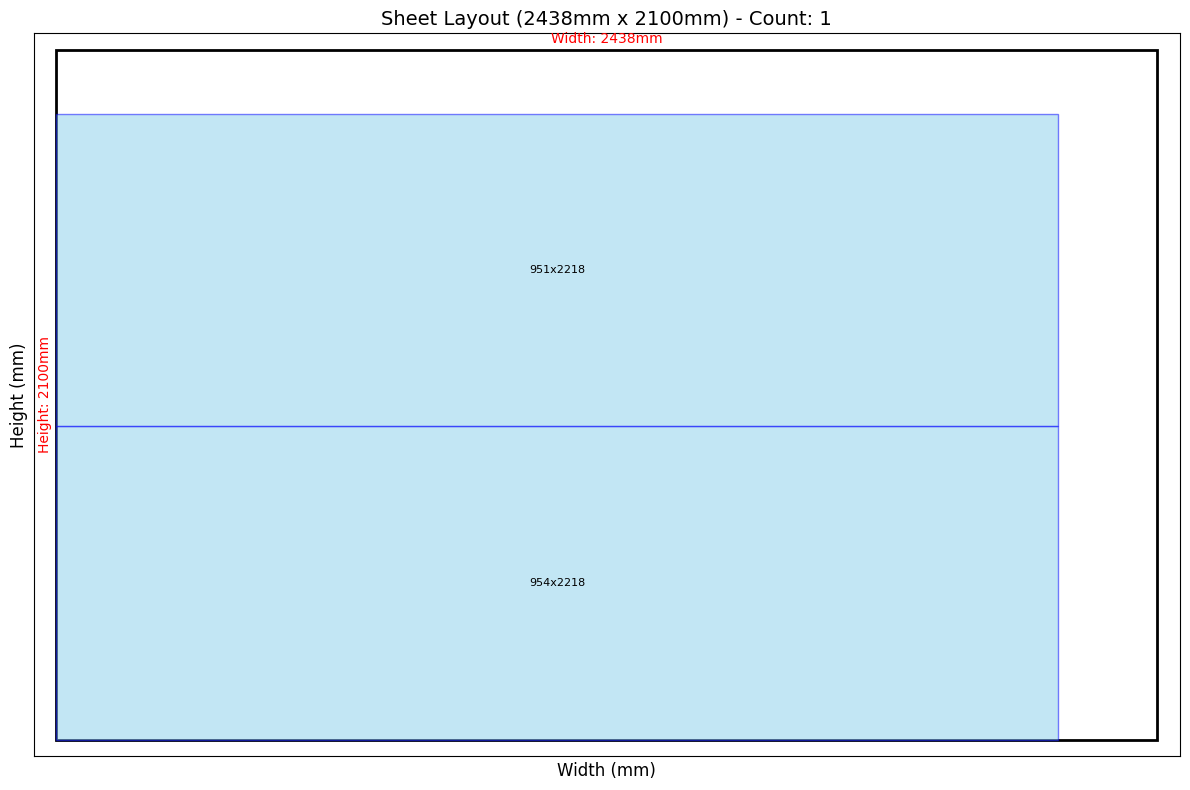

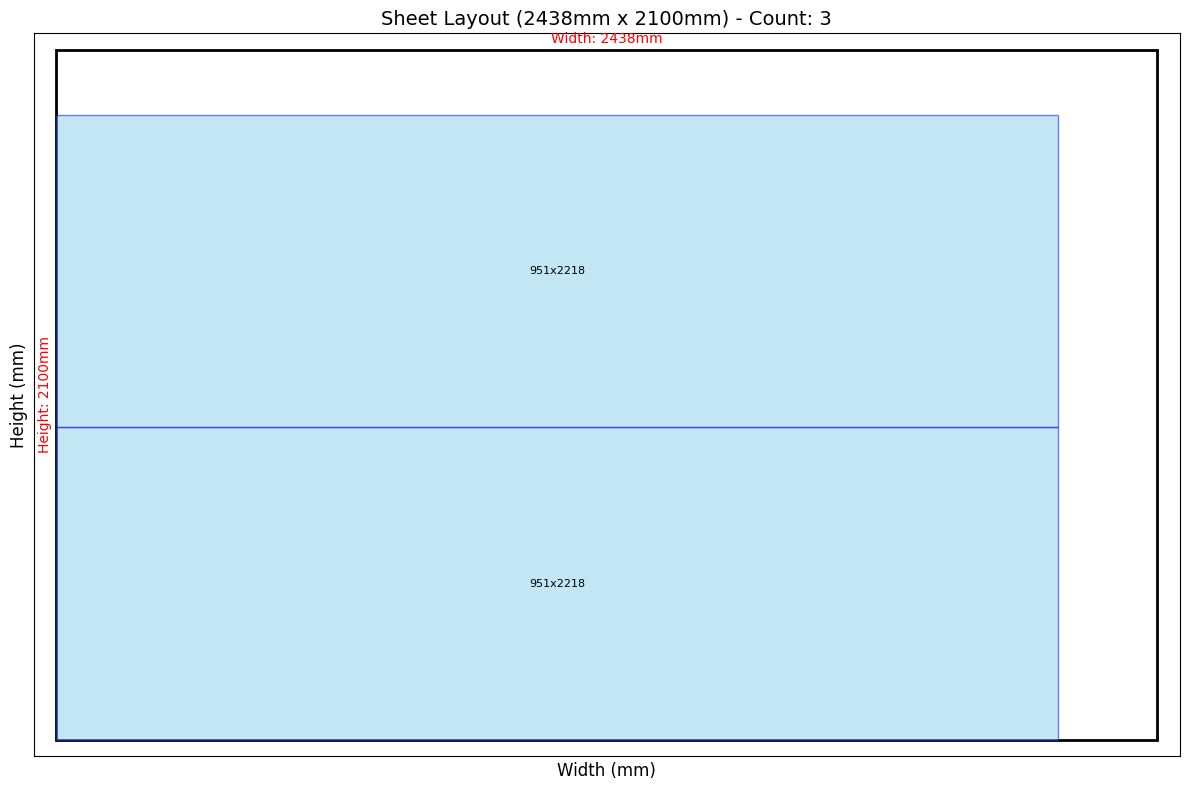

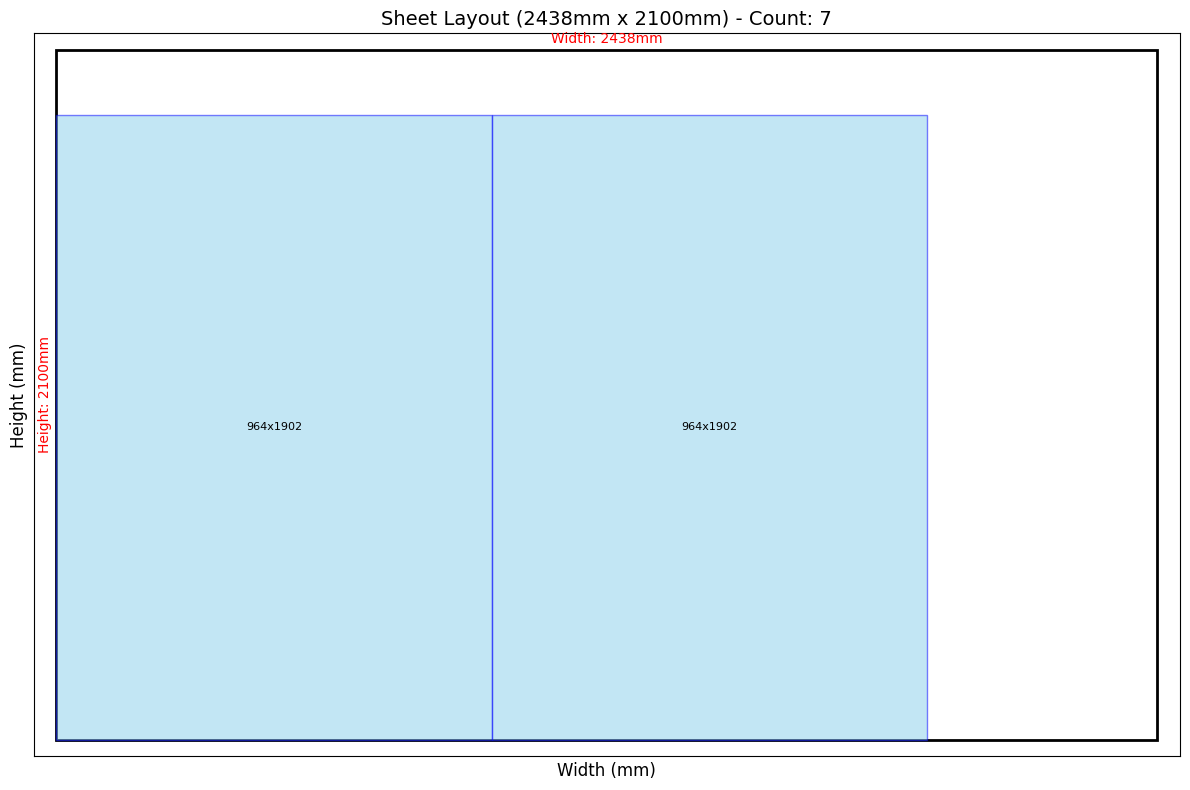

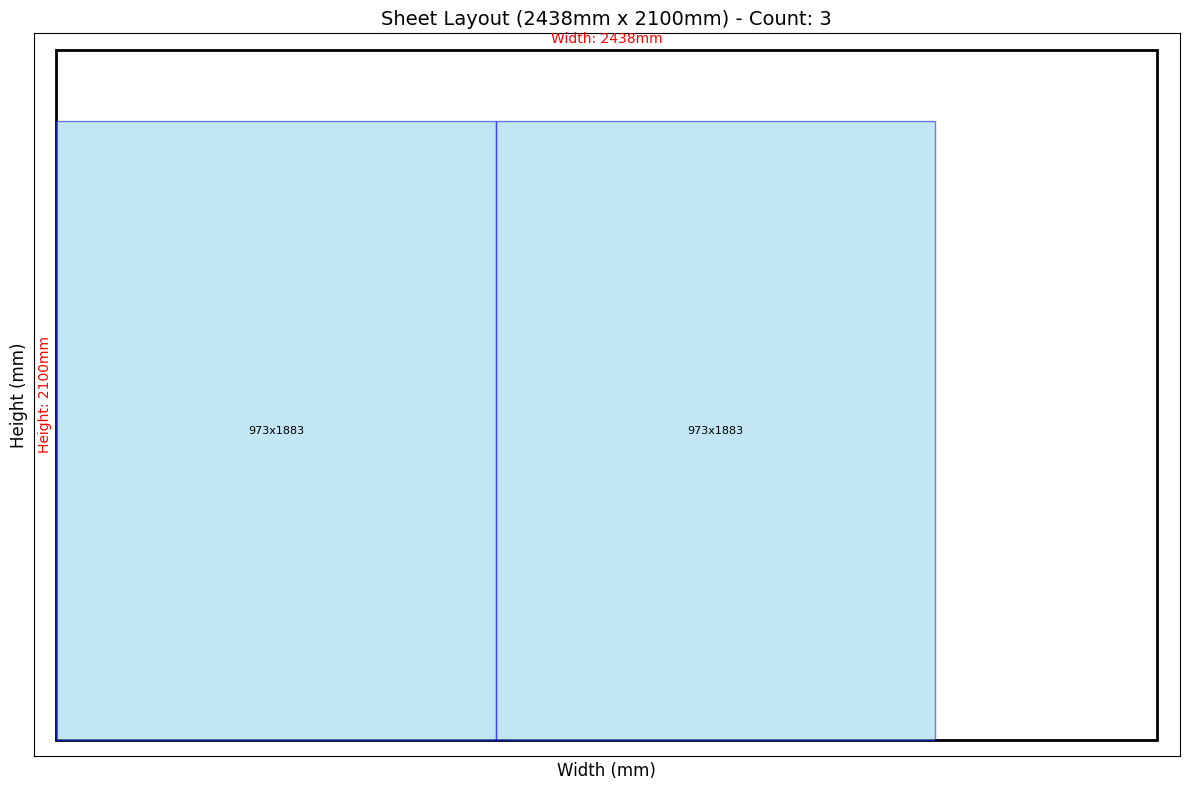

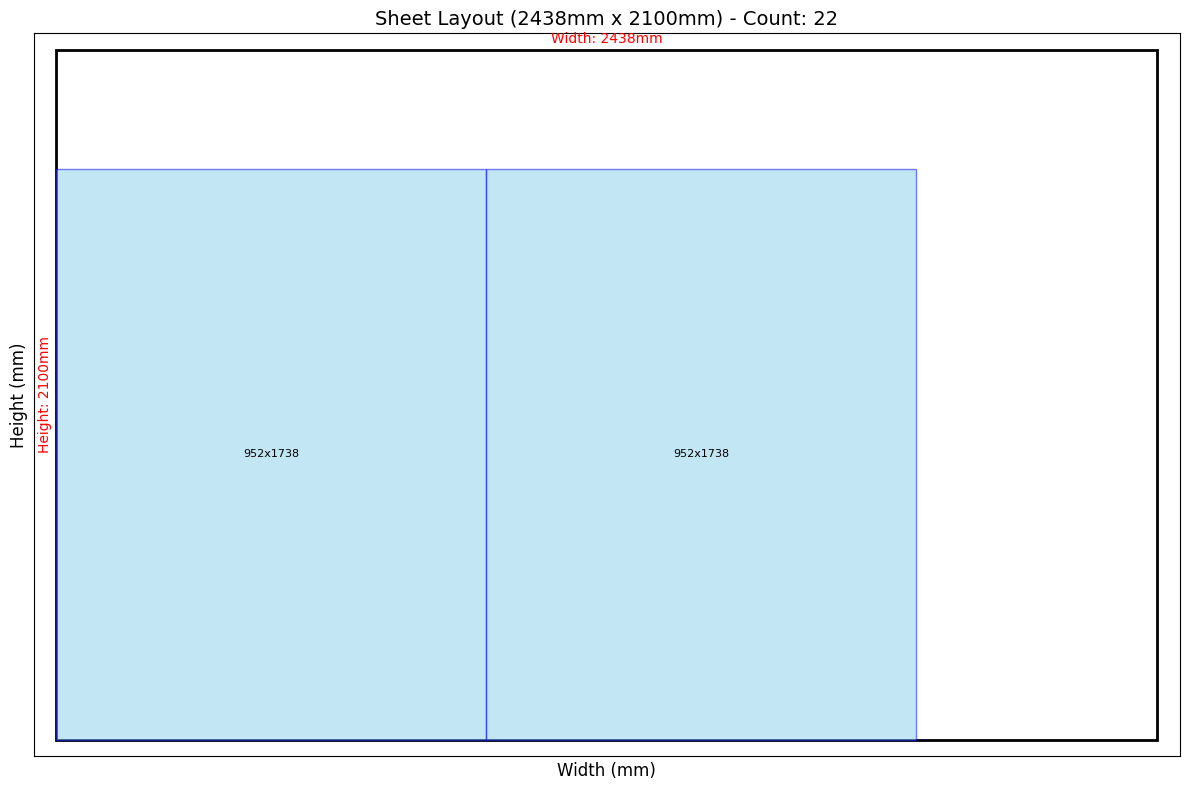

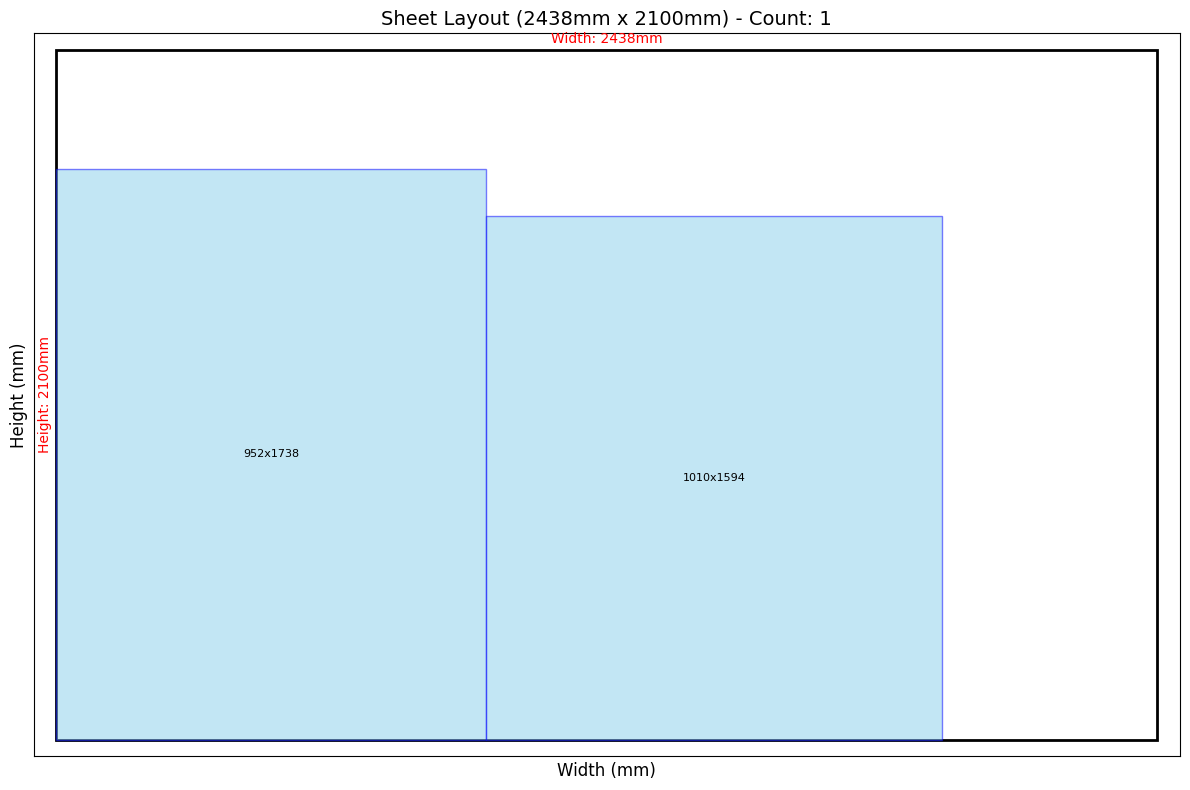

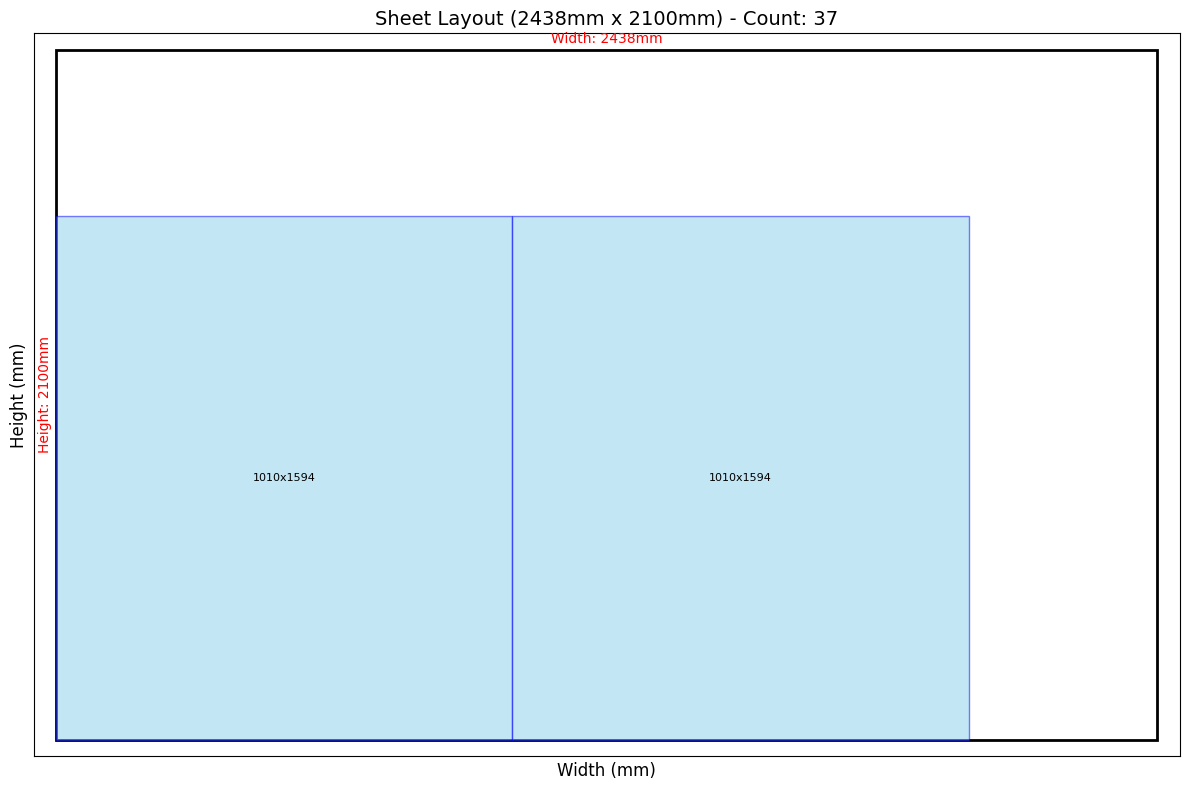

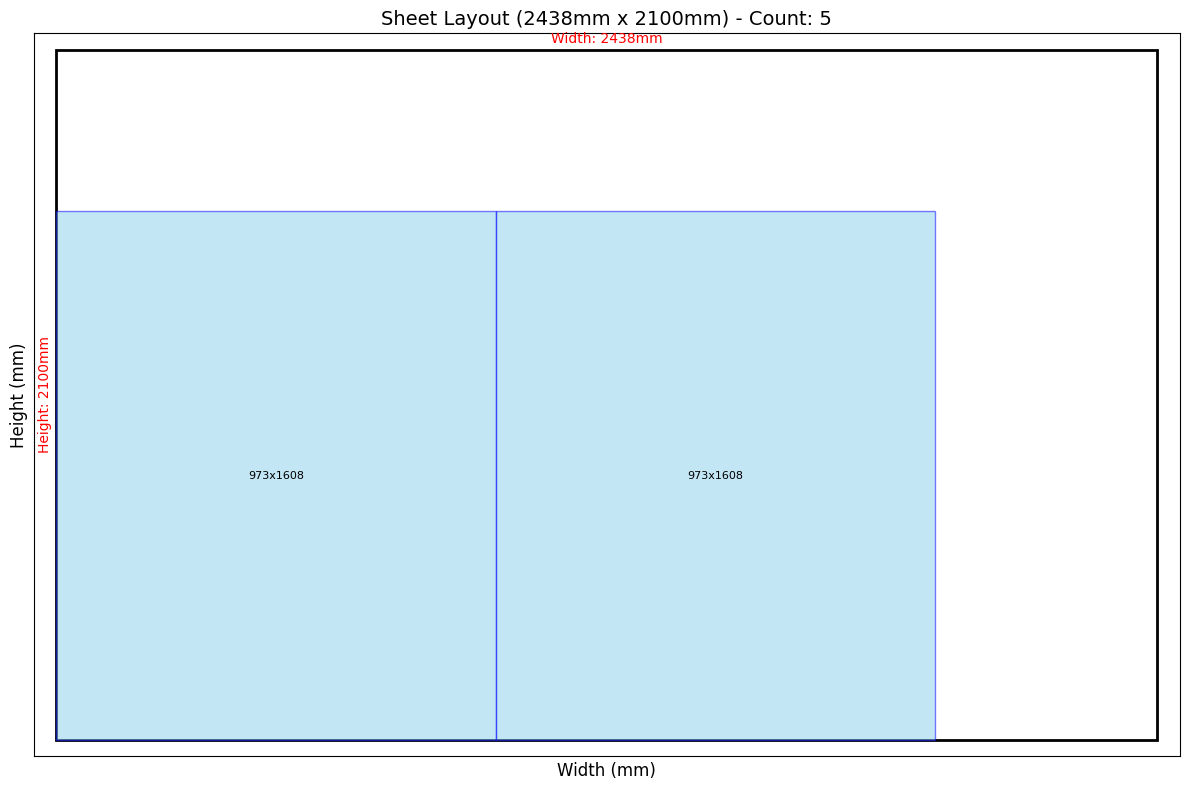

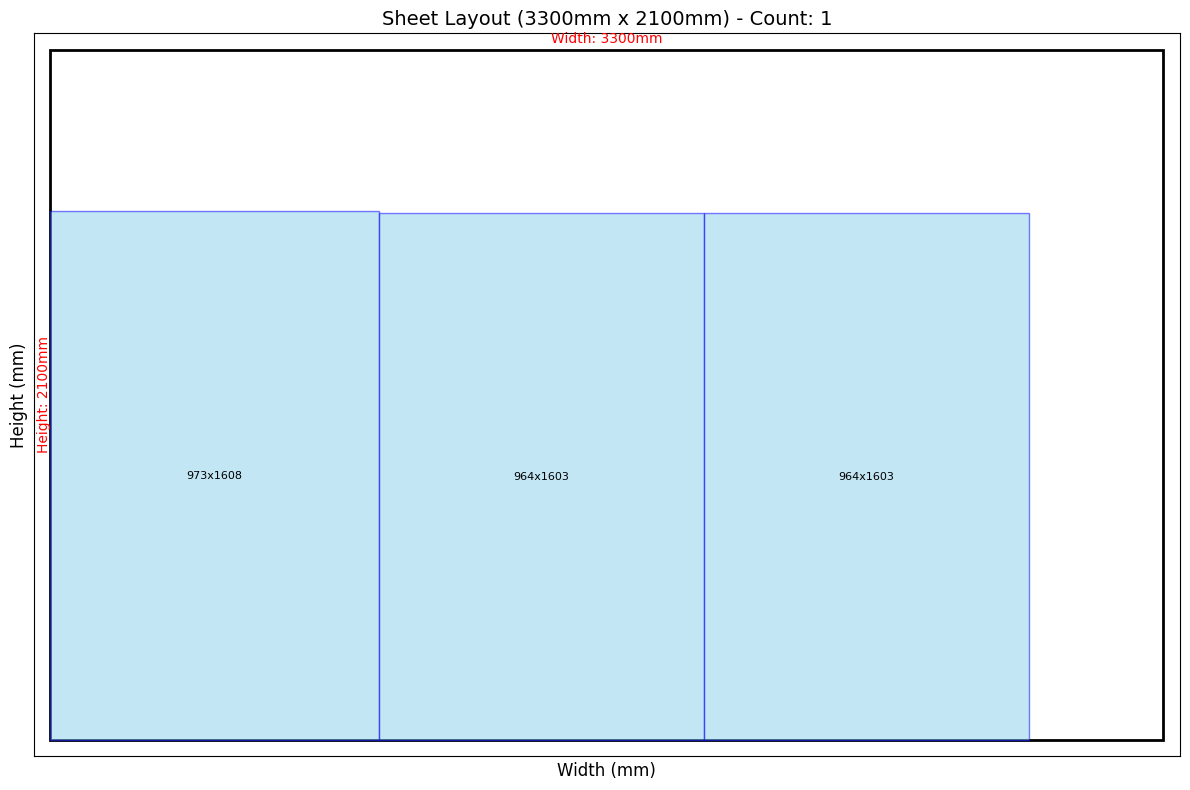

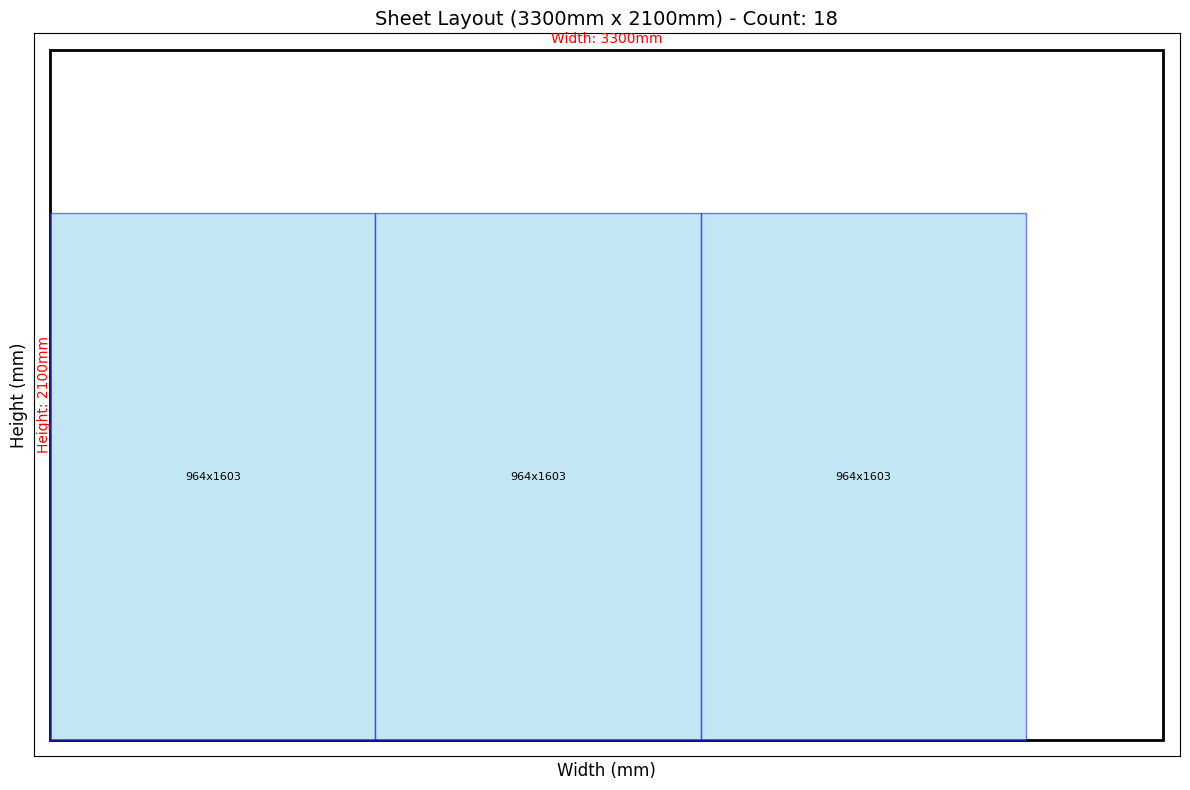

In [1]:
import csv
from typing import List, Dict
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from rectpack import newPacker

# Define file paths
glass_data_file = 'data/glass_data.csv'
stock_sizes_file = 'data/glass_sheet_size1.csv'

gap = 0  # Gap between parts in mm

# Load Data Functions
def load_glass_data(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'location': row['location'], 
                 'length': int(row['glass_length']), 
                 'height': int(row['glass_height']), 
                 'qty': int(row['glass_qty'])} for row in reader]

def load_stock_sizes(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'length': int(row['length']), 
                 'width': int(row['width']), 
                 'qty': int(row['qty'])} for row in reader]

# Expand Parts
def expand_parts(glass_parts: List[Dict]) -> List[Dict]:
    expanded_parts = []
    for part in glass_parts:
        expanded_parts.extend([{'location': part['location'], 'length': part['length'], 'height': part['height']} for _ in range(part['qty'])])
    return expanded_parts

# Layout Optimization using rectpack
def calculate_layout_with_rectpack(parts: List[Dict], stock_sizes: List[Dict], gap: int):
    packer = newPacker(rotation=True)

    # Add parts to the packer
    for part in parts:
        packer.add_rect(part['length'] + gap, part['height'] + gap, part)

    # Add stock sizes to the packer
    for stock in stock_sizes:
        for _ in range(stock['qty']):
            packer.add_bin(stock['length'], stock['width'])

    # Perform packing
    packer.pack()

    # Collect results
    sheets = []
    for i, bin in enumerate(packer):
        sheet = {'size': (bin.width, bin.height), 'placements': []}
        for rect in bin:
            part = rect.rid
            x, y, w, h = rect.x, rect.y, rect.width - gap, rect.height - gap
            rotated = (part['length'], part['height']) != (w, h)
            sheet['placements'].append({'part': part, 'position': (x, y), 'rotated': rotated})
        sheets.append(sheet)

    return sheets

def group_sheets_by_layout(optimized_layout):
    """Group identical sheets and count occurrences properly."""
    sheet_groups = {}
    
    for sheet in optimized_layout:
        layout_signature = frozenset((p['part']['length'], p['part']['height'], p['rotated']) 
                                     for p in sheet['placements'])
        
        if layout_signature in sheet_groups:
            sheet_groups[layout_signature]['count'] += 1
        else:
            sheet_groups[layout_signature] = {'sheet': sheet, 'count': 1}
    
    return [(group['sheet'], group['count']) for group in sheet_groups.values()]

def plot_sheet_layout(sheet_size, placements, sheet_count):
    """Plot a single sheet layout with dynamic bin size labels."""
    sheet_width, sheet_height = sheet_size
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Draw the sheet boundary
    rect = patches.Rectangle((0, 0), sheet_width, sheet_height, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    
    # Draw each placement on the sheet
    for placement in placements:
        part = placement['part']
        position = placement['position']
        rotated = placement['rotated']
        length = part['height'] if rotated else part['length']
        height = part['length'] if rotated else part['height']
        
        # Draw the glass piece
        rect = patches.Rectangle(position, length, height, edgecolor='blue', facecolor='skyblue', alpha=0.5)
        ax.add_patch(rect)
        ax.text(position[0] + length / 2, position[1] + height / 2, 
                f"{part['length']}x{part['height']}", 
                ha='center', va='center', fontsize=8, color='black')
    
    # Add title with sheet count
    ax.set_title(f"Sheet Layout ({sheet_width}mm x {sheet_height}mm) - Count: {sheet_count}", fontsize=14)
    ax.set_xlim(-50, sheet_width + 50)
    ax.set_ylim(-50, sheet_height + 50)
    ax.set_xlabel('Width (mm)', fontsize=12)
    ax.set_ylabel('Height (mm)', fontsize=12)
    
    # Display bin dimensions outside the bin
    ax.text(sheet_width / 2, sheet_height + 20, f"Width: {sheet_width}mm", ha='center', fontsize=10, color='red')
    ax.text(-40, sheet_height / 2, f"Height: {sheet_height}mm", va='center', rotation=90, fontsize=10, color='red')
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

def visualize_optimized_layout(optimized_layout):
    """Visualizes all sheets after optimization."""
    grouped_sheets = group_sheets_by_layout(optimized_layout)
    for sheet, count in grouped_sheets:
        plot_sheet_layout(sheet['size'], sheet['placements'], count)

# Main Optimization with Print and Visualization
def optimize_glass_cutting_with_visuals(glass_data_file: str, stock_sizes_file: str, gap: int):
    glass_parts = load_glass_data(glass_data_file)
    stock_sizes = load_stock_sizes(stock_sizes_file)

    # Expand parts based on quantity
    expanded_parts = expand_parts(glass_parts)

    # Sort parts by area in descending order
    expanded_parts.sort(key=lambda x: x['length'] * x['height'], reverse=True)

    optimized_layout = calculate_layout_with_rectpack(expanded_parts, stock_sizes, gap)

    # Calculate statistics
    total_glass_area_m2 = sum(part['length'] * part['height'] for part in expanded_parts) / 1_000_000
    total_sheet_area_m2 = sum(sheet['size'][0] * sheet['size'][1] for sheet in optimized_layout) / 1_000_000
    used_area_percentage = (total_glass_area_m2 / total_sheet_area_m2) * 100
    wastage_percentage = 100 - used_area_percentage
    sheet_counter = Counter((sheet['size'][0], sheet['size'][1]) for sheet in optimized_layout)

    # Display results
    print(f"Total stock area: {total_sheet_area_m2:.3f} sq m")
    print(f"Total glass area: {total_glass_area_m2:.3f} sq m")
    print(f"Total sheets used: {len(optimized_layout)}")
    print(f"Used area percentage: {used_area_percentage:.2f}%")
    print(f"Wastage percentage: {wastage_percentage:.2f}%")
    print("\nSummary of sheet sizes used:")
    for (length, width), qty in sheet_counter.items():
        print(f"  {length}mm x {width}mm: {qty} pcs")

    # Visualize the layout
    visualize_optimized_layout(optimized_layout)

# Run the function
optimize_glass_cutting_with_visuals(glass_data_file, stock_sizes_file, gap)
